In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

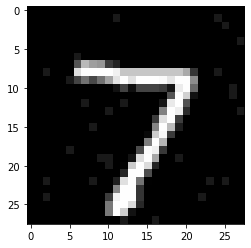

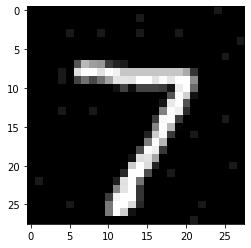

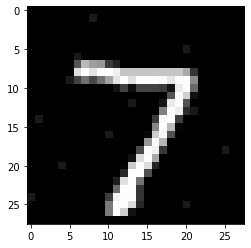

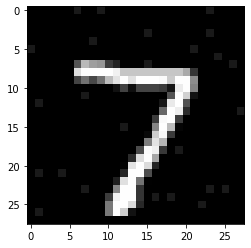

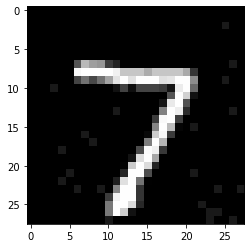

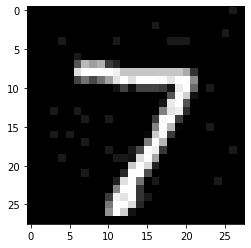

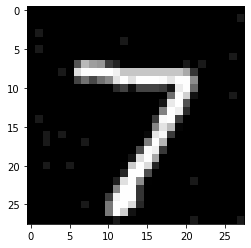

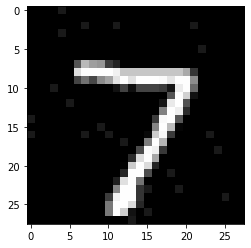

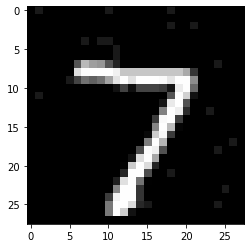

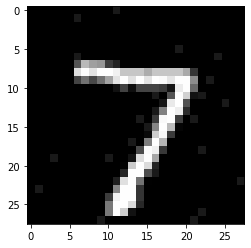

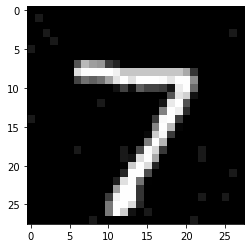

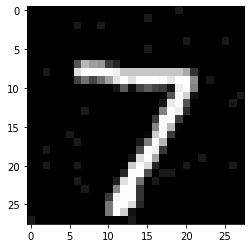

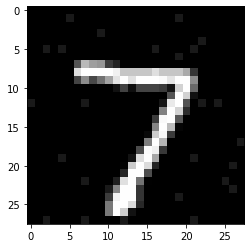

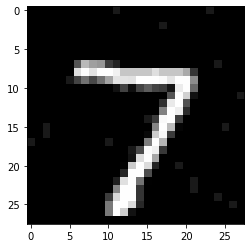

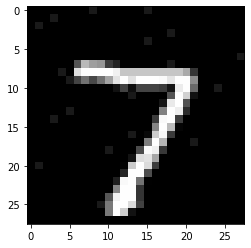

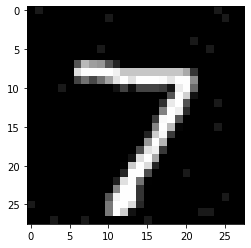

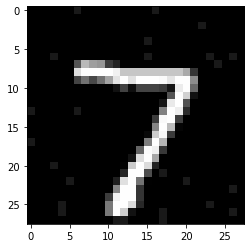

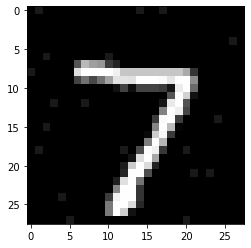

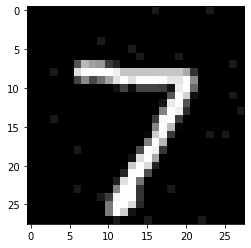

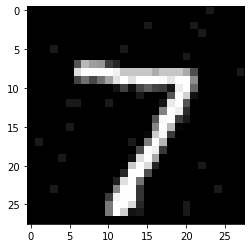

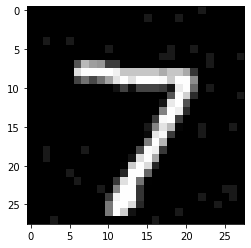

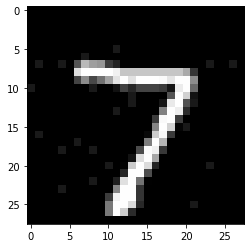

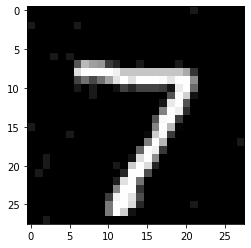

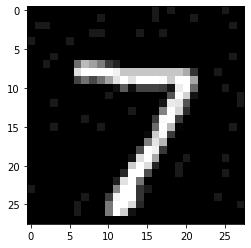

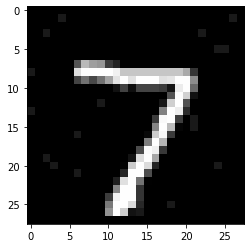

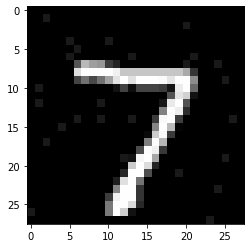

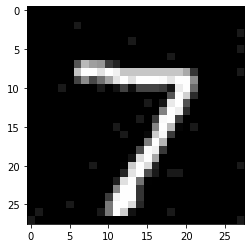

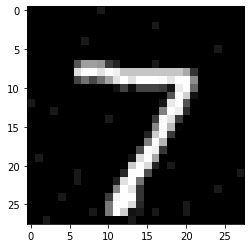

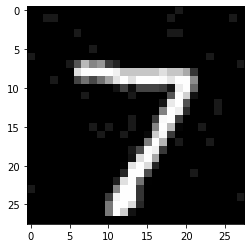

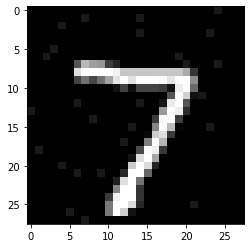

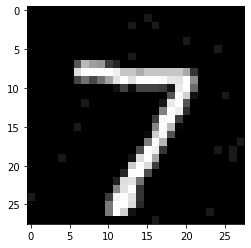

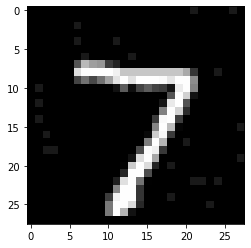

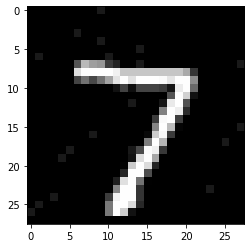

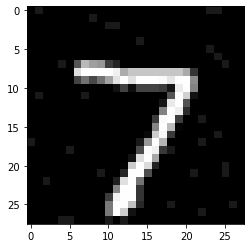

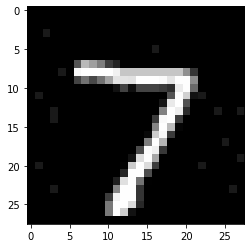

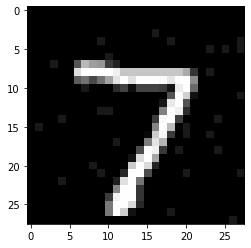

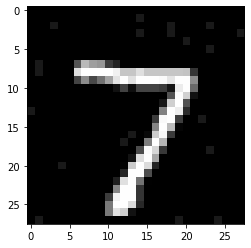

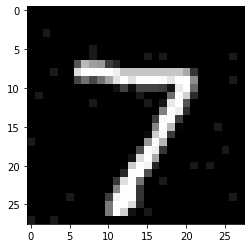

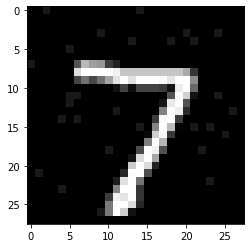

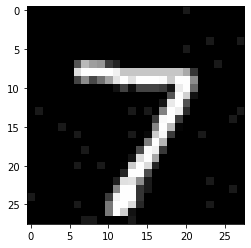

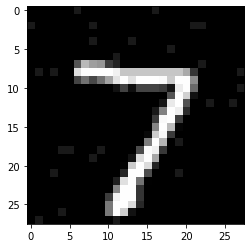

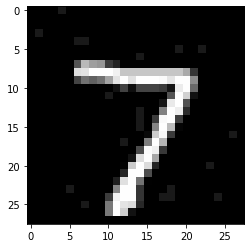

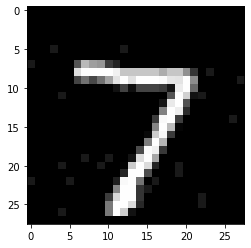

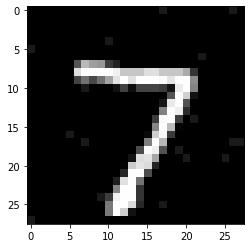

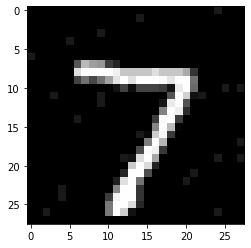

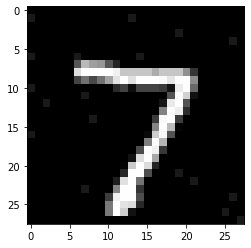

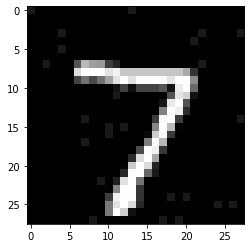

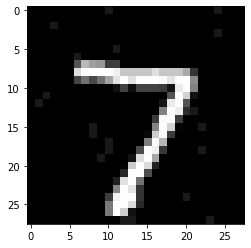

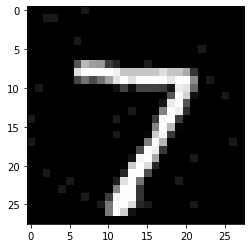

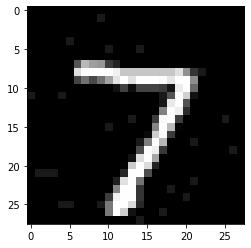

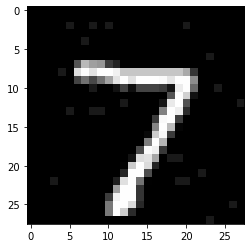

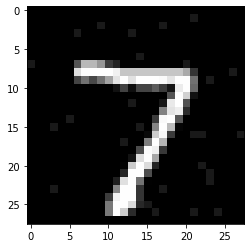

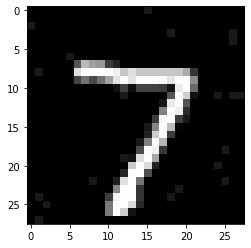

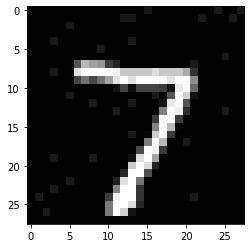

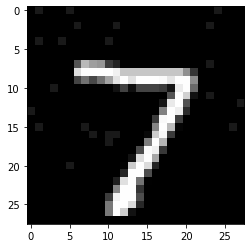

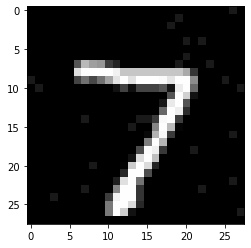

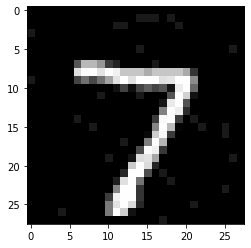

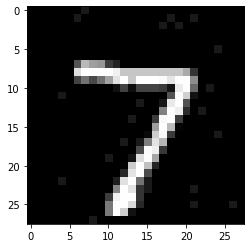

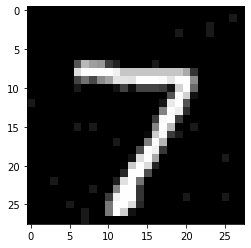

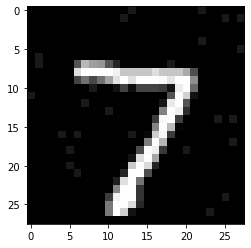

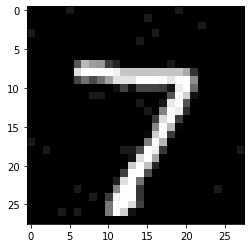

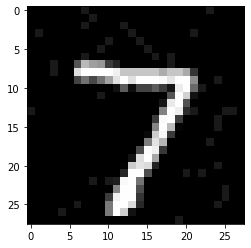

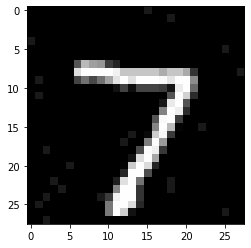

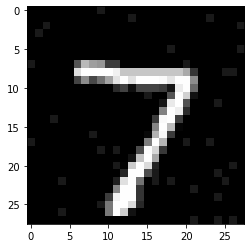

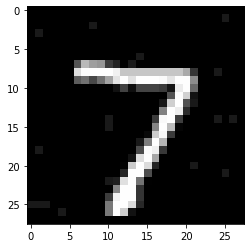

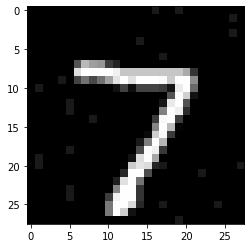

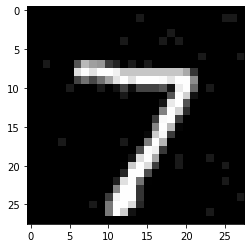

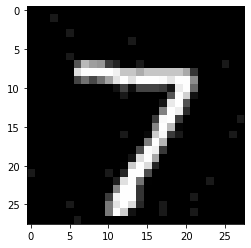

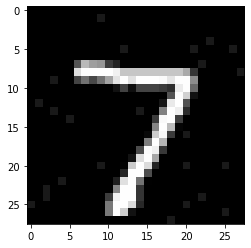

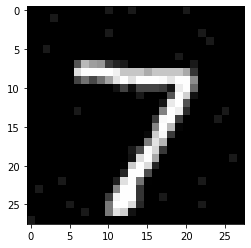

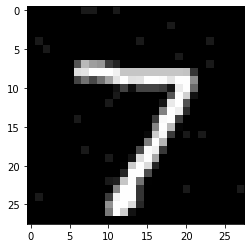

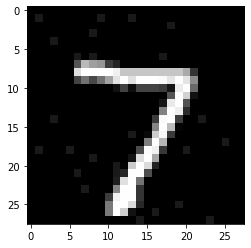

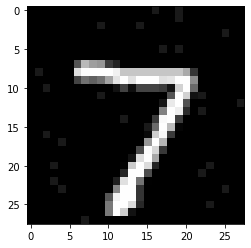

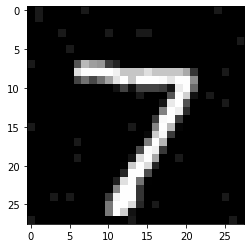

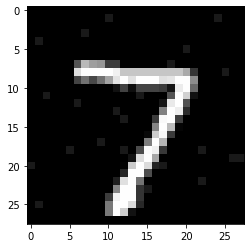

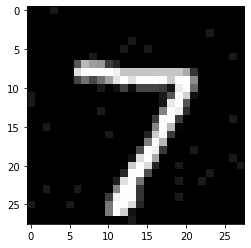

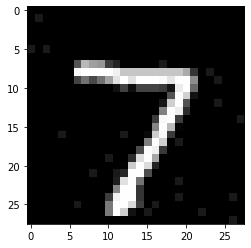

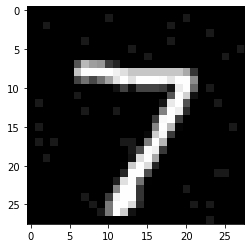

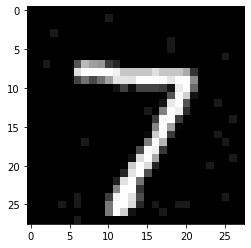

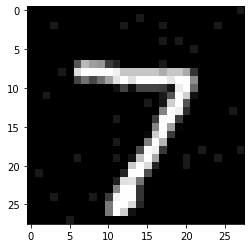

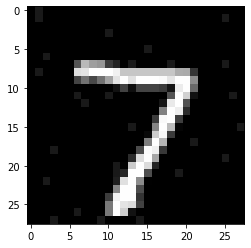

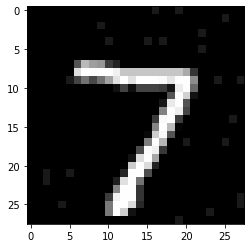

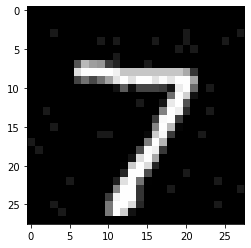

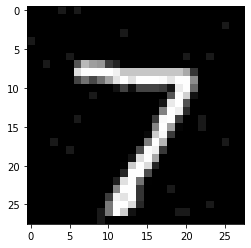

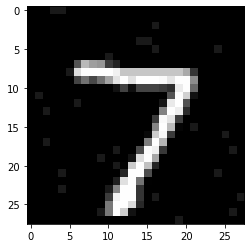

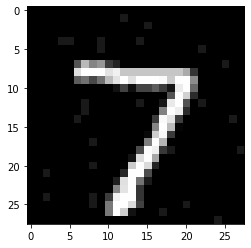

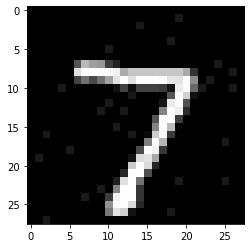

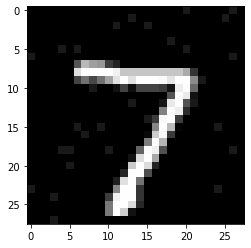

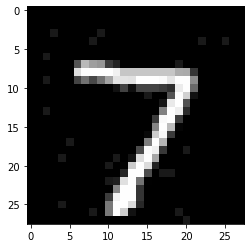

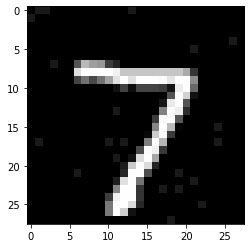

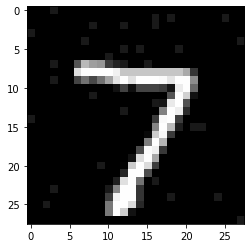

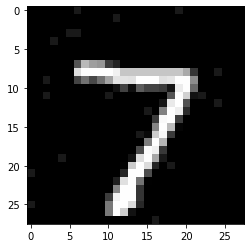

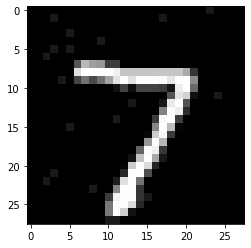

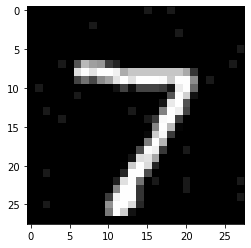

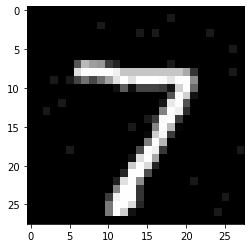

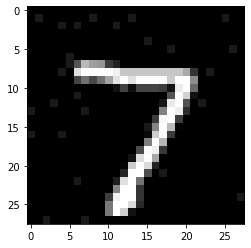

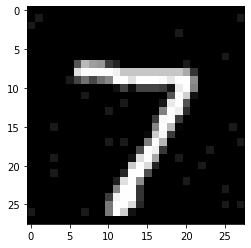

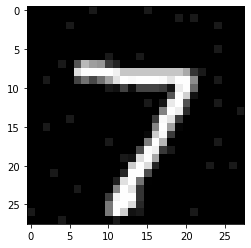

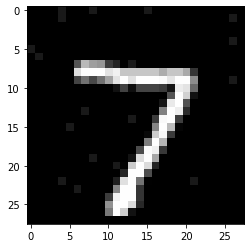

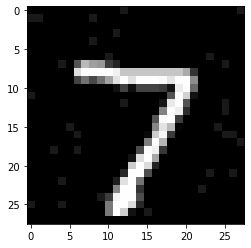

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

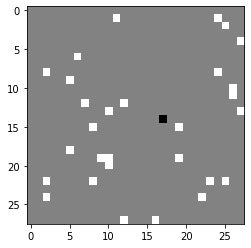

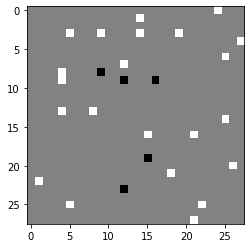

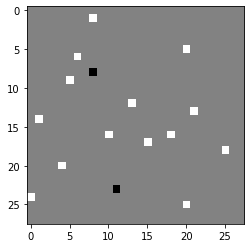

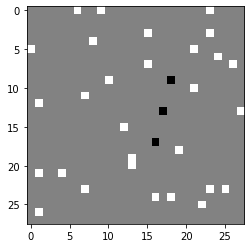

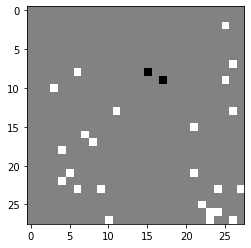

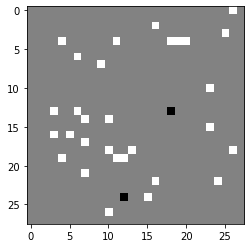

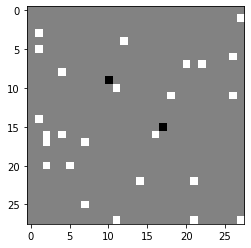

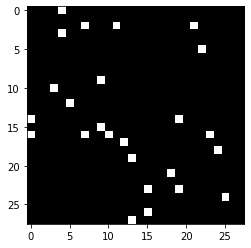

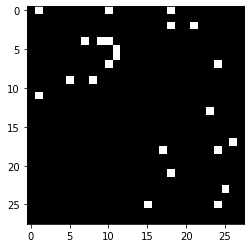

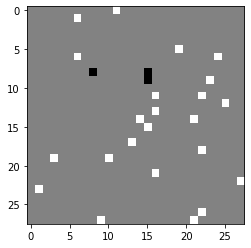

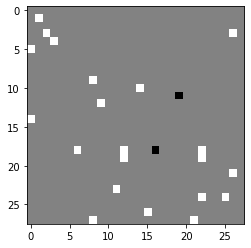

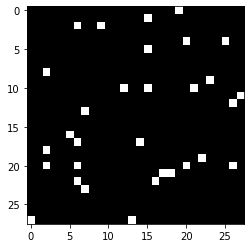

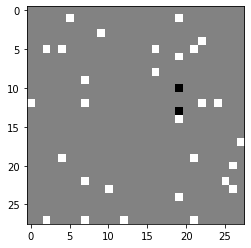

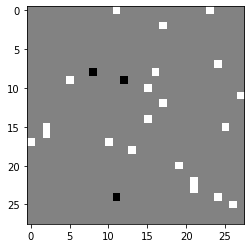

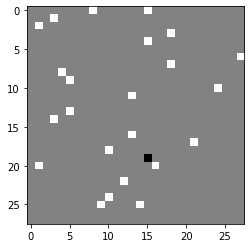

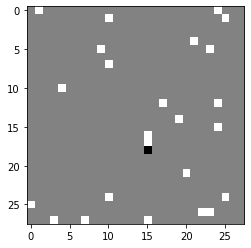

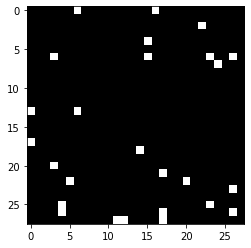

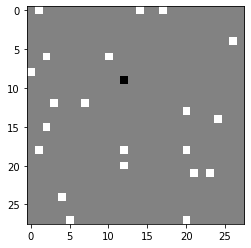

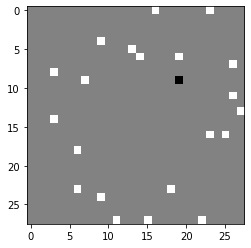

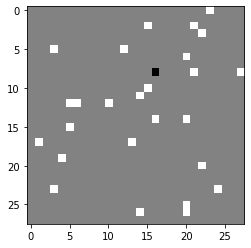

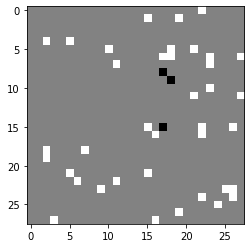

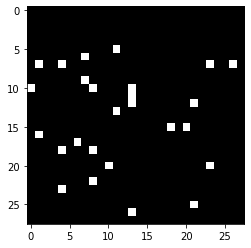

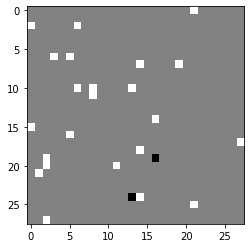

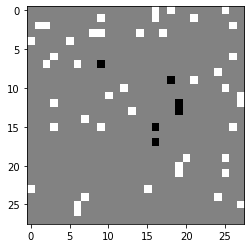

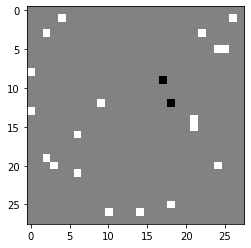

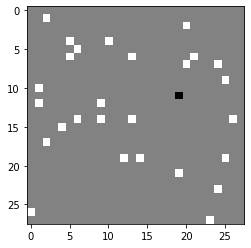

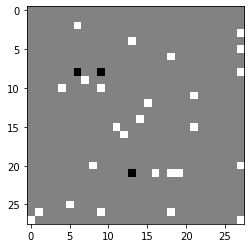

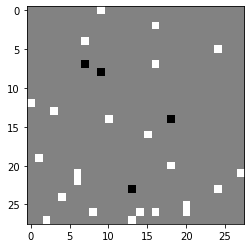

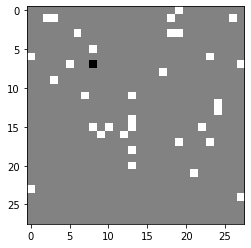

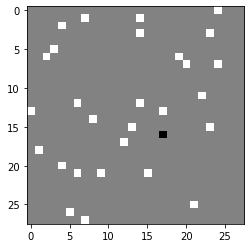

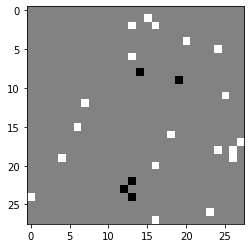

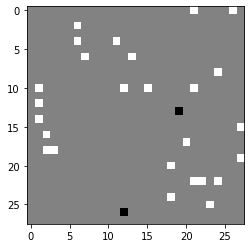

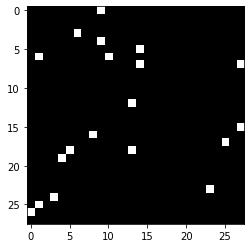

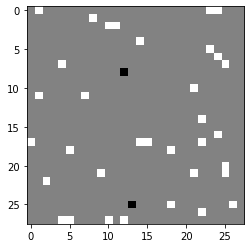

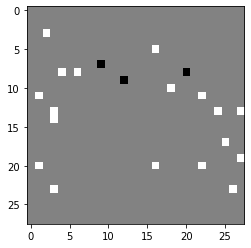

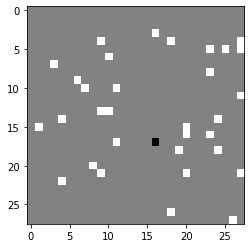

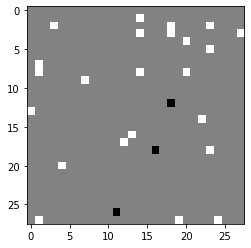

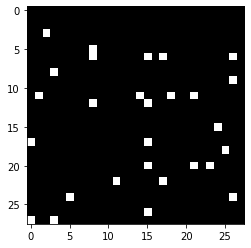

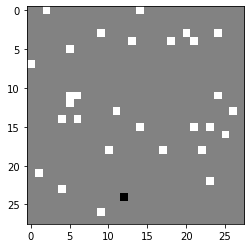

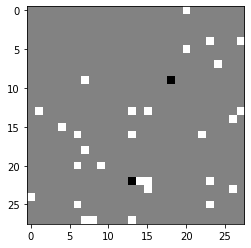

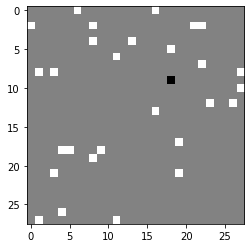

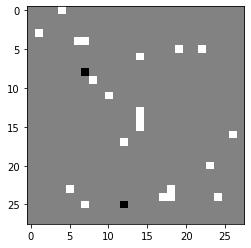

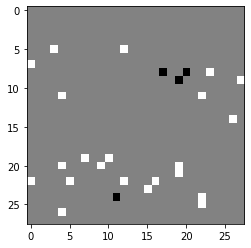

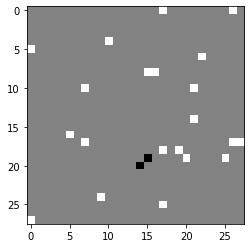

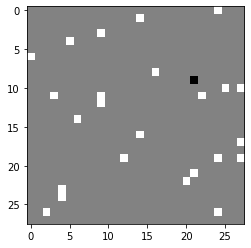

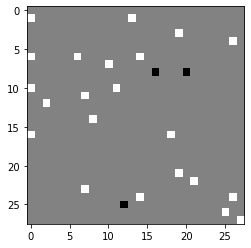

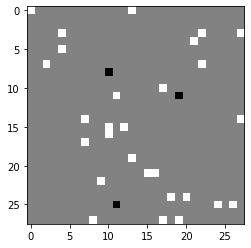

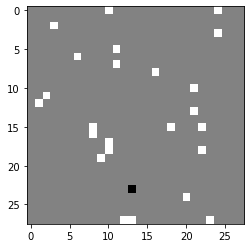

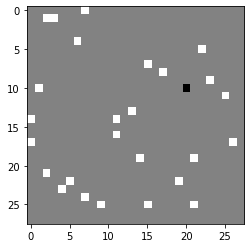

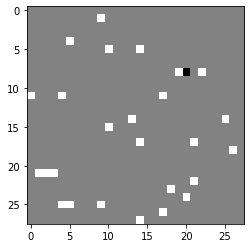

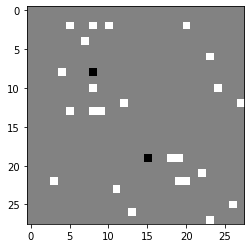

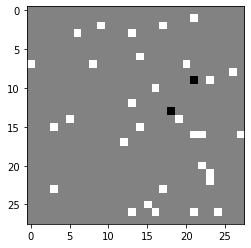

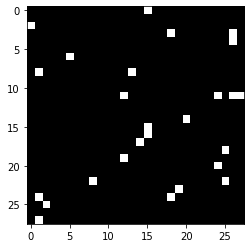

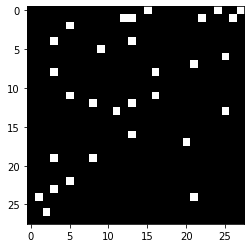

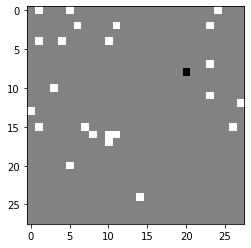

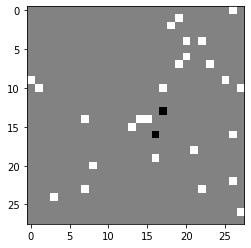

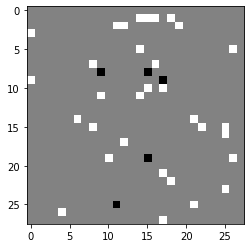

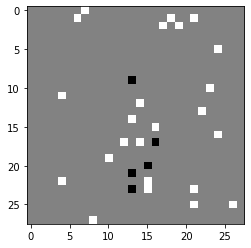

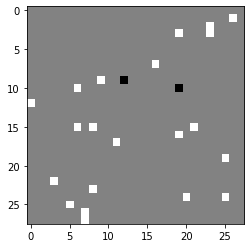

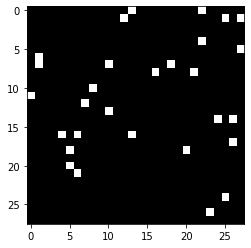

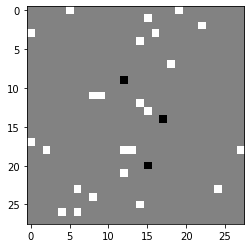

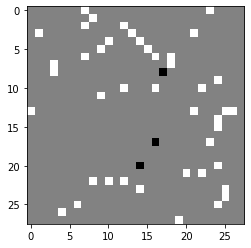

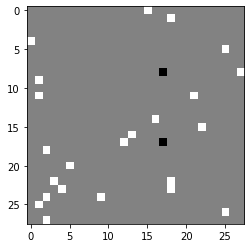

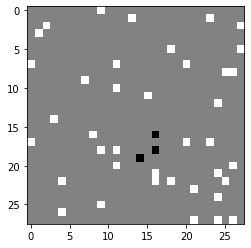

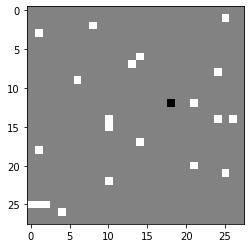

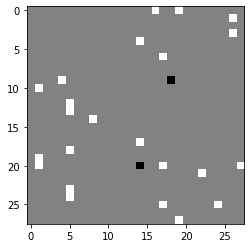

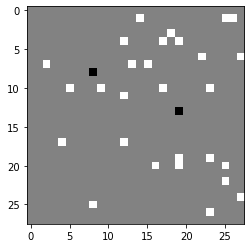

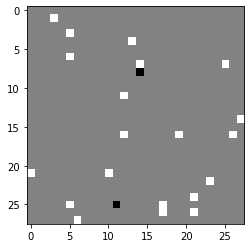

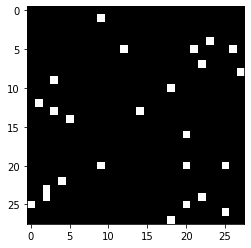

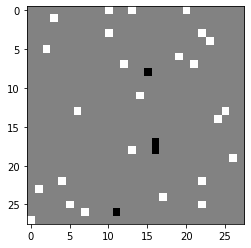

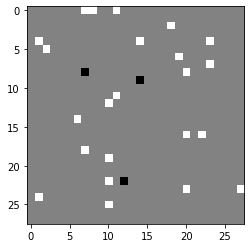

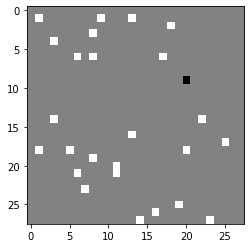

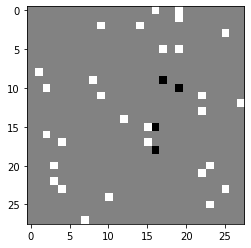

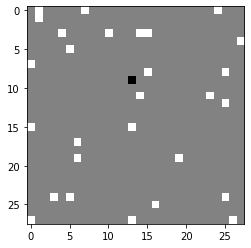

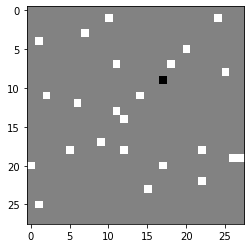

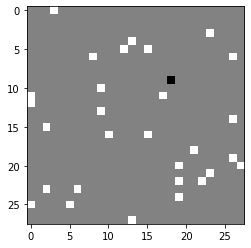

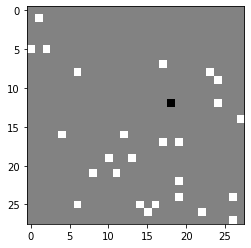

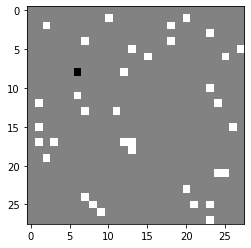

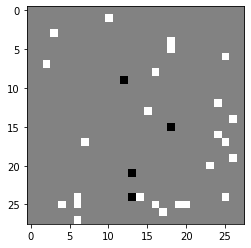

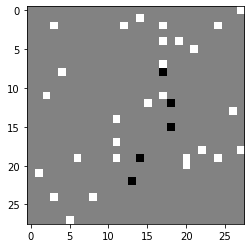

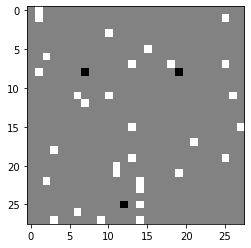

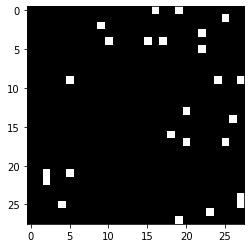

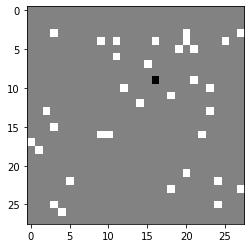

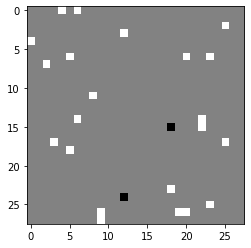

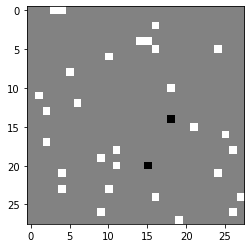

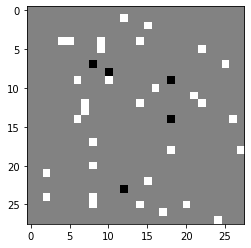

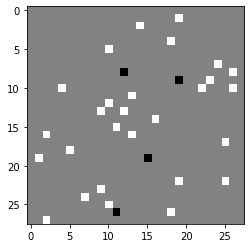

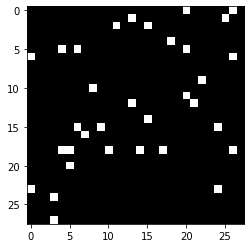

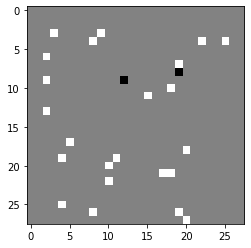

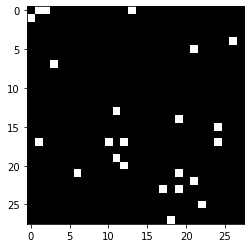

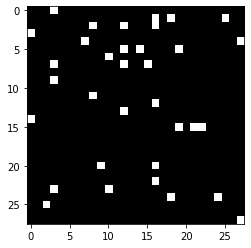

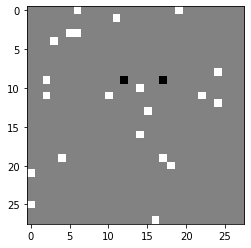

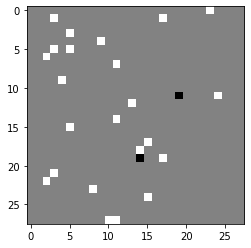

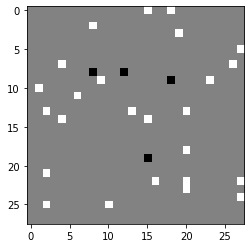

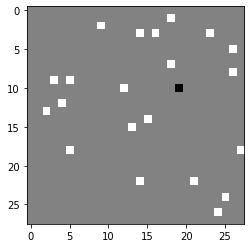

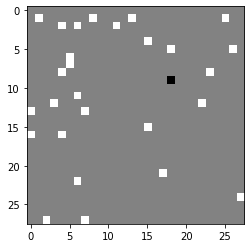

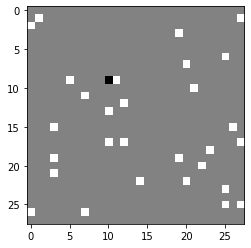

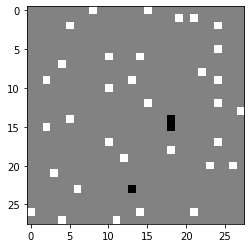

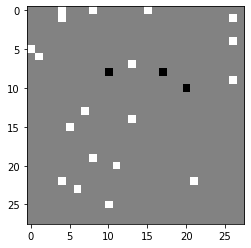

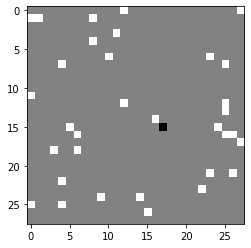

In [5]:
# test
for i in range(100):
    Xr = x_des[i].reshape(28,28)
    plt.imshow(Xr,cmap='gray')
    plt.show()

In [6]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [7]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [8]:
x_train = x_train / 255
x_test = x_test / 255 

In [9]:
model = load_model('mnist_model.h5')

In [10]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [11]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [18]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION: 
        #for t in range(5):
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i]:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X):
                        BEST_X = U[i, :]
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            GENERATION += 1
            
            if Func(BEST_X) < 0.30000000:
                print("resume")
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION:  
        #for t in range(5):
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i]:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X):
                        BEST_X = U[i, :]
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            GENERATION += 1
            
            if Func(BEST_X) >= 0.50000000:
                print("attack")
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [19]:
MAX_GENERATION = 500  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")

GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
re.start()
atk.start()
#atk.join()
#re.join()
#if GENERATION == MAX_GENERATION:
BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
#plt.imshow(BEST_F.reshape(28,28),cmap='gray')
#plt.show()
    #break

attack
最优值： 0.9966543 扰动程度： 0.32217309688581336 代数： 0
最优值： 0.99666023 扰动程度： 0.31965092601307205 代数： 1
最优值： 0.99652725 扰动程度： 0.3708687287812383 代数： 2
最优值： 0.9965429 扰动程度： 0.3589771592280087 代数： 3
最优值： 0.99650514 扰动程度： 0.35973945146945435 代数： 4
最优值： 0.9964941 扰动程度： 0.3237629350177869 代数： 5
最优值： 0.99619675 扰动程度： 0.3527403318413857 代数： 6
最优值： 0.9961635 扰动程度： 0.3564119994338597 代数： 7
最优值： 0.99612695 扰动程度： 0.3558998770183285 代数： 8
最优值： 0.99595284 扰动程度： 0.47264683545614516 代数： 9
最优值： 0.9958548 扰动程度： 0.4720480974591824 代数： 10
最优值： 0.99583095 扰动程度： 0.49908047936865557 代数： 11
最优值： 0.9955675 扰动程度： 0.3984170717431365 代数： 12
最优值： 0.9954848 扰动程度： 0.44916157367912457 代数： 13
最优值： 0.9950257 扰动程度： 0.6240720967856419 代数： 14
最优值： 0.9949758 扰动程度： 0.6315993076186607 代数： 15
最优值： 0.99491525 扰动程度： 0.6371830782826037 代数： 16
最优值： 0.99481505 扰动程度： 0.6403614180241595 代数： 17
最优值： 0.99452657 扰动程度： 0.8158566624076072 代数： 18
最优值： 0.99442285 扰动程度： 0.5830107611424492 代数： 19
最优值： 0.9943177 扰动程度： 0.773946676031983 代数： 20


最优值： 0.66686285 扰动程度： 9.082365512337551 代数： 175
最优值： 0.65252054 扰动程度： 9.181936856677662 代数： 176
最优值： 0.65432054 扰动程度： 9.375824627701055 代数： 177
最优值： 0.65438205 扰动程度： 9.344090745627184 代数： 178
最优值： 0.6440868 扰动程度： 9.376988663187035 代数： 179
最优值： 0.6252334 扰动程度： 9.60944419918689 代数： 180
最优值： 0.6269861 扰动程度： 9.591848224381561 代数： 181
最优值： 0.6259775 扰动程度： 9.646649992341878 代数： 182
最优值： 0.6242325 扰动程度： 9.408521759451412 代数： 183
最优值： 0.6219787 扰动程度： 9.635806455656462 代数： 184
最优值： 0.62172765 扰动程度： 9.63724023172634 代数： 185
最优值： 0.61175984 扰动程度： 9.914697287132384 代数： 186
最优值： 0.5999316 扰动程度： 10.20057076489418 代数： 187
最优值： 0.5932796 扰动程度： 10.07682760022026 代数： 188
最优值： 0.59400326 扰动程度： 10.050298930609754 代数： 189
最优值： 0.5848548 扰动程度： 10.042775079822539 代数： 190
最优值： 0.58565944 扰动程度： 10.027284547046257 代数： 191
最优值： 0.5768486 扰动程度： 10.301973727437781 代数： 192
最优值： 0.5709701 扰动程度： 10.391761419296145 代数： 193
最优值： 0.57240963 扰动程度： 10.273936426921196 代数： 194
最优值： 0.56827784 扰动程度： 10.719850281963849 代数： 19

最优值： 0.3157598 扰动程度： 12.18109464177667 代数： 345
最优值： 0.30600092 扰动程度： 12.430397908478326 代数： 346
最优值： 0.30090836 扰动程度： 12.52549230974982 代数： 347
最优值： 0.30177552 扰动程度： 12.51272620220472 代数： 348
最优值： 0.30076823 扰动程度： 12.528071433463689 代数： 349
最优值： 0.29273218 扰动程度： 13.147517782645753 代数： 350
resume
最优值： 0.35225967 扰动程度： 11.386402932298891 代数： 351
最优值： 0.36097795 扰动程度： 11.032864449640588 代数： 352
最优值： 0.36326367 扰动程度： 10.948607460431303 代数： 353
最优值： 0.35414472 扰动程度： 10.935584674941001 代数： 354
最优值： 0.37313044 扰动程度： 10.917632426452457 代数： 355
最优值： 0.3663928 扰动程度： 10.76176625086503 代数： 356
最优值： 0.3678105 扰动程度： 10.74433170559973 代数： 357
最优值： 0.3891241 扰动程度： 10.592515434656896 代数： 358
最优值： 0.38924006 扰动程度： 10.574588801186529 代数： 359
最优值： 0.40097895 扰动程度： 10.54760042396702 代数： 360
最优值： 0.40673262 扰动程度： 10.483472406058132 代数： 361
最优值： 0.4017757 扰动程度： 10.424592521400239 代数： 362
最优值： 0.42312714 扰动程度： 10.222732043421676 代数： 363
最优值： 0.4223227 扰动程度： 10.232546043060891 代数： 364
最优值： 0.4147639 扰动程度： 10.1

In [20]:
BEST_X

array([ 0.00000000e+00,  1.26735148e-01,  1.39035156e-04,  0.00000000e+00,
        2.79439228e-02,  0.00000000e+00,  1.41153872e-01,  0.00000000e+00,
        2.11260062e-02,  2.04846078e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.33830841e-02,
        2.64419425e-02,  1.12253706e-02,  5.94558367e-02,  4.15427195e-02,
        2.14753188e-02,  5.40040314e-06,  1.33133087e-01,  0.00000000e+00,
        6.95938540e-03,  0.00000000e+00,  7.71061238e-03,  1.20979712e-01,
        1.90906238e-04,  0.00000000e+00,  7.79246482e-04,  1.89839565e-03,
        1.17708699e-02,  0.00000000e+00,  0.00000000e+00,  1.46001725e-02,
        0.00000000e+00,  2.45215243e-01,  0.00000000e+00,  2.13271582e-03,
        0.00000000e+00,  1.73050315e-02,  7.14797547e-02,  6.00243751e-03,
        1.26875286e-03,  0.00000000e+00,  1.22684835e-02,  6.27442564e-03,
        0.00000000e+00,  5.24553163e-03,  3.64109150e-03,  0.00000000e+00,
        0.00000000e+00,  

In [21]:
BEST_F

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09803922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09803922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09803922,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09803922, 0.        ,
       0.        , 0.        , 0.        , 0.09803922, 0.     

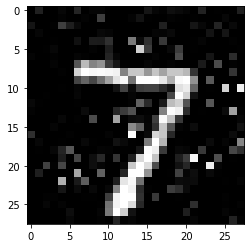

In [22]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [23]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03606191, 0.13325453, 0.30351505, 0.14268604, 0.03217717,
       0.18159828, 0.06348677, 0.01640903, 0.07245255, 0.01835869],
      dtype=float32)

In [14]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

448


In [15]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

4


In [55]:
V=[1.175,0.8,1.5,1.32,1.912]
for i in range(5):
                    if V[i] > 1:
                        V[i] =1-(V[i]-1)
                       
V = [round(i,3) for i in V]
V

[0.825, 0.8, 0.5, 0.68, 0.088]